# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [63]:
import pandas as pd  # import the neccessary libraries
pd.set_option('display.max_columns', 300)  # display all the columns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor  # In case we want to use k-nearest neighbor model
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn')
sns.set(style="white")

In [30]:
house = pd.read_csv('kc_house_data_train.csv')  # read in the csv file with train data
print(house.shape)  # check the dimensions of the model
house.head()  # print the first 5 rows

(17290, 22)


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [31]:
house.dtypes  # check the column types

Unnamed: 0         int64
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.

In [32]:
print(house['id'].nunique())  # check if all rows have a unique id
house['id'].value_counts(dropna = False).head() 

17176


1232000810    2
3558900590    2
3323059027    2
3935900232    2
3630120700    2
Name: id, dtype: int64

* Not all the id values are unique. Are there houses that were sold multiple times? Let's check out some of these entries and see what's going on.

In [33]:
house[(house['id'] == 1232000810) | (house['id'] == 3558900590)]

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7491,7491,1232000810,20140912T000000,340000.0,3,2.50,1400,4800,1.0,0,0,3,7,1200,200,1921,0,98117,47.6865,-122.379,1440,3840
11136,11136,1232000810,20150326T000000,537000.0,3,2.50,1400,4800,1.0,0,0,3,7,1200,200,1921,0,98117,47.6865,-122.379,1440,3840
12664,12664,3558900590,20150324T000000,692500.0,6,1.75,2230,10080,1.0,0,0,3,7,1390,840,1969,0,98034,47.7089,-122.201,2110,8475
16139,16139,3558900590,20141125T000000,360000.0,6,1.75,2230,10080,1.0,0,0,3,7,1390,840,1969,0,98034,47.7089,-122.201,2110,8475


* From this, we can conclude that some house were sold multiple times for different prices. Therefore, the **date** a house is sold is related to the price

In [34]:
# let's drop the first two columns as they are not useful for our model
# sqft_living = sqft_above + sqft_basement
house.drop(columns=['Unnamed: 0', 'id','sqft_above','sqft_basement',], inplace=True)

In [35]:
house.isnull().sum().any() # check if there are any null values

False

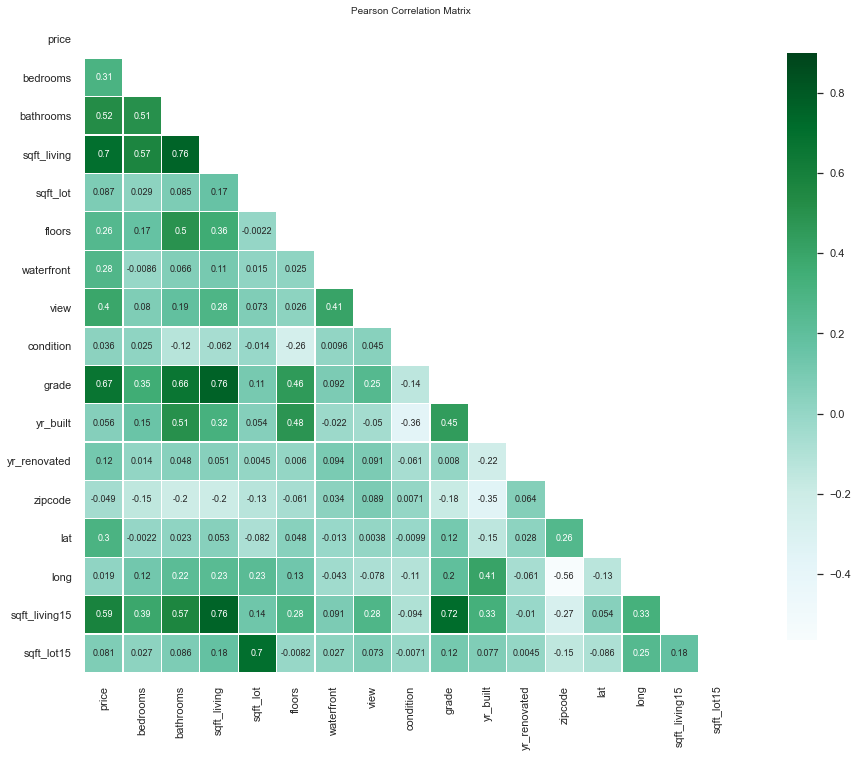

In [36]:
# let's check the correlation between the features

mask = np.zeros_like(house.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(house.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()

* we may be able to drop `sqft_living15` since it is highly correlated with **grade** and **sqft_above**
* `sqft_lot15` has high correlation with **sqft_lot** and very low correlation with **price**

## Step 3: Clean up any issues with the data like extreme values.  

remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout dataset, and you can't just delete those rows and not have a prediction for it. 

## Step 4: Generate new features that you think could be important

After doing this, you will want to go back to steps 2 and 3 to investigates these new features

In [37]:
# transform 'yr_built' column to a column that tells us how old a house is
house['yrs_old'] = 2016 - house['yr_built']  # create new column to store this data
house.yrs_old.describe()

count    17290.000000
mean        45.207981
std         29.343516
min          1.000000
25%         20.000000
50%         42.000000
75%         65.000000
max        116.000000
Name: yrs_old, dtype: float64

In [38]:
house[house.yr_renovated == 0]['yr_renovated'].count()  # check how many houses have not been renovated

16564

Many houses have not been renovated. Therefore, we can consider turning this into a boolean column.

### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [39]:
# If a house has been renovated assign 1, if not assign 0
house['renovated'] = house['yr_renovated'].apply(lambda x: (1 if  x > 0 else 0))
house.renovated.value_counts()

0    16564
1      726
Name: renovated, dtype: int64

### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

In [40]:
house['year_sold'] = house['date'].str[0:4].astype(int)  # create a column to check when these houses were sold

In [41]:
house.year_sold.unique()  # check which years these houses have been sold

array([2014, 2015])

In [42]:
house.groupby('year_sold')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
year_sold,,,,,,,,
2014,11703.0,541341.601299,377104.805515,78000.0,320000.0,450000.0,650000.0,7700000.0
2015,5587.0,539478.438518,365291.881178,75000.0,325000.0,450000.0,637000.0,5350000.0


This dataset contains only two years of sales data. There isn't much of a difference in price statistics between btoh years.

In [43]:
house['month_sold'] = house['date'].str[4:6].astype(int) # create a column to check what month houses were sold

In [44]:
# create a new interaction feature by adding 'bedrooms' and 'bathrooms' columns
house['bed_bath'] = house['bedrooms'] + house['bathrooms']

In [45]:
np.abs(house.corr()['price'])  # lets check possible feature correlations with the price column

price            1.000000
bedrooms         0.305106
bathrooms        0.524335
sqft_living      0.703540
sqft_lot         0.086803
floors           0.256985
waterfront       0.275779
view             0.395485
condition        0.036099
grade            0.666215
yr_built         0.056450
yr_renovated     0.117770
zipcode          0.048958
lat              0.302394
long             0.019327
sqft_living15    0.585567
sqft_lot15       0.081423
yrs_old          0.056450
renovated        0.117409
year_sold        0.002334
month_sold       0.004350
bed_bath         0.464420
Name: price, dtype: float64

`sqft_lot`,`condition`,`sqft_lot15`,`year_sold`,`yrs_old` seem to have very little correlation with the target column.

In [27]:
features =['sqft_living','floors','waterfront','view','grade','bed_bath','renovated','yrs_old',
          'sqft_lot15','sqft_living15','condition']
df = house[features].copy()
df['price'] = house['price']

In [47]:
df_scaled = (df - df.mean())/df.std()

In [48]:
df_scaled['price'] = df['price']

In [50]:
df_scaled.head()

,sqft_living,floors,waterfront,view,grade,bed_bath,renovated,yrs_old,sqft_lot15,sqft_living15,condition,price
0,-0.012461,0.945776,-0.089695,-0.307676,0.294177,0.514857,-0.20935,-0.518274,-0.190010,0.587050,0.908187,365000.0
1,0.889694,-0.909823,-0.089695,-0.307676,0.294177,1.691733,-0.20935,-0.211562,-0.242053,0.557844,2.443588,865000.0
2,1.835328,0.945776,-0.089695,2.272207,2.847981,0.682983,-0.20935,-0.893144,-0.117105,2.514613,-0.627215,1038000.0
3,2.694006,0.945776,-0.089695,2.272207,3.699249,0.682983,-0.20935,-0.654590,0.049675,3.011106,-0.627215,1490000.0
4,0.509267,0.945776,-0.089695,-0.307676,1.145445,0.010482,-0.20935,-1.131697,-0.324066,0.382611,-0.627215,711000.0


In [51]:
from statsmodels.formula.api import ols

lr_model = ols(formula='price~sqft_living+floors+grade+waterfront+yrs_old+renovated+view', 
               data=df_scaled).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     4456.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:51:22   Log-Likelihood:            -2.3745e+05
No. Observations:               17290   AIC:                         4.749e+05
Df Residuals:                   17282   BIC:                         4.750e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.407e+05   1695.590    318.909      0.000    5.37e+05    5.44e+05
sqft_living  1.549e+05   2657.706     58.278      0.000     1.5e+05     1.6e+05
floors       1.676e+04   2051.189      8.173      0.000    1.27e+04    2.08e+04
grade         1.54e+05   2859.499     53.868      0.000    1.48e+05     1.6e+05
waterfront   5.337e+04   1861.287     28.674      0.000    4.97e+04     5.7e+04
yrs_old      1.017e+05   2125.395     47.848      0.000    9.75e+04    1.06e+05
renovated    3455.6442   1770.283      1.952      0.051     -14.290    6925.578
view         3.777e+04   1958.456     19.287      0.000    3.39e+04    4.16e+04
==============================================================================
Omnibus:                    13812.734   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1166720.089
Skew:                           3.267   Prob(JB):                         0.00
Kurtosis:                      42.709   Cond. No.                         3.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step 5: Train Test Split

If you plan on doing any sclaing of your data, make sure it is doen at the apporpriate time. 

### 5.1) Perform a train test split of the data.

In [55]:
df_features = house[features]

target = house['price']

In [56]:
df_features.isnull().mean()

sqft_living      0.0
floors           0.0
waterfront       0.0
view             0.0
grade            0.0
bed_bath         0.0
renovated        0.0
yrs_old          0.0
sqft_lot15       0.0
sqft_living15    0.0
condition        0.0
dtype: float64

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9,test_size=0.25)

In [58]:
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=df_features.columns)

#transform the testing data
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df_features.columns)

In [64]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 221850.76332392415


### Evaluate on the test set

In [65]:
#use fitted model to predict on the test examples
y_test_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 221501.43689621554
Training:  221850 vs. Testing:  221501


## Generate Polynomial and Interaction features


In [66]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
print(df_poly2.shape)
df_poly2.head()

(17290, 77)


,sqft_living,floors,waterfront,view,grade,bed_bath,renovated,yrs_old,sqft_lot15,sqft_living15,condition,sqft_living^2,sqft_living floors,sqft_living waterfront,sqft_living view,sqft_living grade,sqft_living bed_bath,sqft_living renovated,sqft_living yrs_old,sqft_living sqft_lot15,sqft_living sqft_living15,sqft_living condition,floors^2,floors waterfront,floors view,floors grade,floors bed_bath,floors renovated,floors yrs_old,floors sqft_lot15,floors sqft_living15,floors condition,waterfront^2,waterfront view,waterfront grade,waterfront bed_bath,waterfront renovated,waterfront yrs_old,waterfront sqft_lot15,waterfront sqft_living15,waterfront condition,view^2,view grade,view bed_bath,view renovated,view yrs_old,view sqft_lot15,view sqft_living15,view condition,grade^2,grade bed_bath,grade renovated,grade yrs_old,grade sqft_lot15,grade sqft_living15,grade condition,bed_bath^2,bed_bath renovated,bed_bath yrs_old,bed_bath sqft_lot15,bed_bath sqft_living15,bed_bath condition,renovated^2,renovated yrs_old,renovated sqft_lot15,renovated sqft_living15,renovated condition,yrs_old^2,yrs_old sqft_lot15,yrs_old sqft_living15,yrs_old condition,sqft_lot15^2,sqft_lot15 sqft_living15,sqft_lot15 condition,sqft_living15^2,sqft_living15 condition,condition^2
0,2070.0,2.0,0.0,0.0,8.0,6.25,0.0,30.0,7700.0,2390.0,4.0,4284900.0,4140.0,0.0,0.0,16560.0,12937.5,0.0,62100.0,15939000.0,4947300.0,8280.0,4.0,0.0,0.0,16.0,12.5,0.0,60.0,15400.0,4780.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,50.0,0.0,240.0,61600.0,19120.0,32.0,39.0625,0.0,187.5,48125.0,14937.5,25.0,0.0,0.0,0.0,0.0,0.0,900.0,231000.0,71700.0,120.0,59290000.0,18403000.0,30800.0,5712100.0,9560.0,16.0
1,2900.0,1.0,0.0,0.0,8.0,8.00,0.0,39.0,6283.0,2370.0,5.0,8410000.0,2900.0,0.0,0.0,23200.0,23200.0,0.0,113100.0,18220700.0,6873000.0,14500.0,1.0,0.0,0.0,8.0,8.0,0.0,39.0,6283.0,2370.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,64.0,0.0,312.0,50264.0,18960.0,40.0,64.0000,0.0,312.0,50264.0,18960.0,40.0,0.0,0.0,0.0,0.0,0.0,1521.0,245037.0,92430.0,195.0,39476089.0,14890710.0,31415.0,5616900.0,11850.0,25.0
2,3770.0,2.0,0.0,2.0,11.0,6.50,0.0,19.0,9685.0,3710.0,3.0,14212900.0,7540.0,0.0,7540.0,41470.0,24505.0,0.0,71630.0,36512450.0,13986700.0,11310.0,4.0,0.0,4.0,22.0,13.0,0.0,38.0,19370.0,7420.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,22.0,13.0,0.0,38.0,19370.0,7420.0,6.0,121.0,71.5,0.0,209.0,106535.0,40810.0,33.0,42.2500,0.0,123.5,62952.5,24115.0,19.5,0.0,0.0,0.0,0.0,0.0,361.0,184015.0,70490.0,57.0,93799225.0,35931350.0,29055.0,13764100.0,11130.0,9.0
3,4560.0,2.0,0.0,2.0,12.0,6.50,0.0,26.0,14226.0,4050.0,3.0,20793600.0,9120.0,0.0,9120.0,54720.0,29640.0,0.0,118560.0,64870560.0,18468000.0,13680.0,4.0,0.0,4.0,24.0,13.0,0.0,52.0,28452.0,8100.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,24.0,13.0,0.0,52.0,28452.0,8100.0,6.0,144.0,78.0,0.0,312.0,170712.0,48600.0,36.0,42.2500,0.0,169.0,92469.0,26325.0,19.5,0.0,0.0,0.0,0.0,0.0,676.0,369876.0,105300.0,78.0,202379076.0,57615300.0,42678.0,16402500.0,12150.0,9.0
4,2550.0,2.0,0.0,0.0,9.0,5.50,0.0,12.0,4050.0,2250.0,3.0,6502500.0,5100.0,0.0,0.0,22950.0,14025.0,0.0,30600.0,10327500.0,5737500.0,7650.0,4.0,0.0,0.0,18.0,11.0,0.0,24.0,8100.0,4500.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,49.5,0.0,108.0,36450.0,20250.0,27.0,30.2500,0.0,66.0,22275.0,12375.0,16.5,0.0,0.0,0.0,0.0,0.0,144.0,48600.0,27000.0,36.0,16402500.0,9112500.0,12150.0,5062500.0,6750.0,9.0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=9,test_size=0.2)

In [68]:
scaler2 = StandardScaler()
# fit the scaler to the training data
scaler2.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=df_poly2.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=df_poly2.columns)

In [69]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 188075.03771685372


In [70]:
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 192051.40511035317
Training:  188075 vs. Testing:  192051


## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models

### 6.1) Utilize a filter method to identify some features to remove from the model.  


In [82]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_lasso01) )
print('Testing Error: '+ str(test_rmse_lasso01) )

Training Error: 125872.73236746162
Testing Error: 192058.77443401632


/Users/farhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 244262166855198.0, tolerance: 194982925380.51126
  model = cd_fast.enet_coordinate_descent(


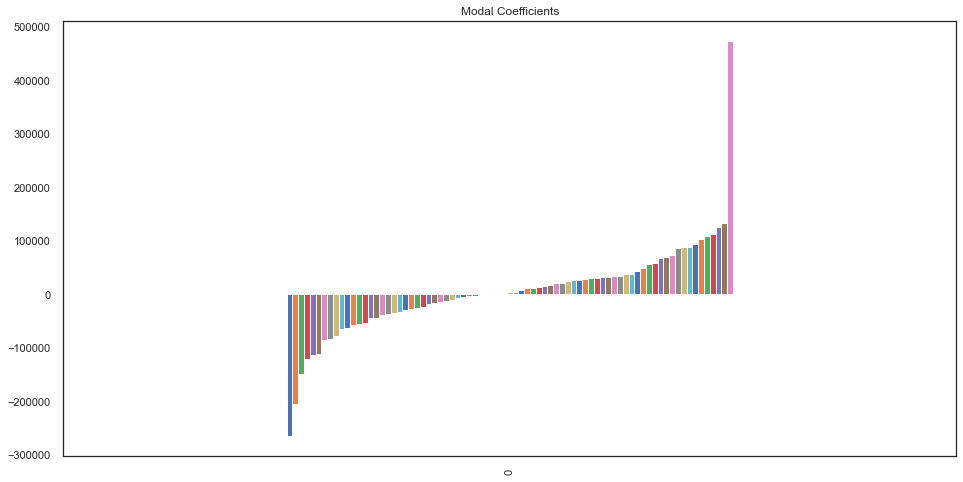

In [86]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [84]:
print('Original: \t', test_rmse, '\n',
      "Lasso 0.01: \t",  test_rmse_lasso01, '\n')

Original: 	 192051.40511035317 
 Lasso 0.01: 	 192058.77443401632 



In [73]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=20)

selector.fit(X_train, y_train)

SelectKBest(k=20, score_func=<function f_regression at 0x7fc12c9c2670>)

In [74]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [76]:
list(removed_columns)

['floors',
 'waterfront',
 'view',
 'bed_bath',
 'renovated',
 'yrs_old',
 'sqft_lot15',
 'condition',
 'sqft_living waterfront',
 'sqft_living renovated',
 'sqft_living yrs_old',
 'sqft_living sqft_lot15',
 'floors^2',
 'floors waterfront',
 'floors view',
 'floors grade',
 'floors bed_bath',
 'floors renovated',
 'floors yrs_old',
 'floors sqft_lot15',
 'floors condition',
 'waterfront^2',
 'waterfront view',
 'waterfront grade',
 'waterfront bed_bath',
 'waterfront renovated',
 'waterfront yrs_old',
 'waterfront sqft_lot15',
 'waterfront sqft_living15',
 'waterfront condition',
 'view^2',
 'view grade',
 'view renovated',
 'view yrs_old',
 'view sqft_lot15',
 'view condition',
 'grade renovated',
 'grade yrs_old',
 'grade sqft_lot15',
 'bed_bath^2',
 'bed_bath renovated',
 'bed_bath yrs_old',
 'bed_bath sqft_lot15',
 'bed_bath condition',
 'renovated^2',
 'renovated yrs_old',
 'renovated sqft_lot15',
 'renovated sqft_living15',
 'renovated condition',
 'yrs_old^2',
 'yrs_old sqft_lo

In [77]:
list(selected_columns)

['sqft_living',
 'grade',
 'sqft_living15',
 'sqft_living^2',
 'sqft_living floors',
 'sqft_living view',
 'sqft_living grade',
 'sqft_living bed_bath',
 'sqft_living sqft_living15',
 'sqft_living condition',
 'floors sqft_living15',
 'view bed_bath',
 'view sqft_living15',
 'grade^2',
 'grade bed_bath',
 'grade sqft_living15',
 'grade condition',
 'bed_bath sqft_living15',
 'sqft_living15^2',
 'sqft_living15 condition']

In [78]:
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])

trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))

print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 219985.49519180087
Testing Root Mean Squared Error: 206804.64833537565


## Step 7: Evaluate your different models in order to determine the best model overall

In [85]:
print('Original: \t', test_rmse, '\n',
      "KBest: \t", testK_rmse, '\n',
      "Lasso 0.01: \t",  test_rmse_lasso01, '\n')

Original: 	 192051.40511035317 
 KBest: 	 206804.64833537565 
 Lasso 0.01: 	 192058.77443401632 



## Step 8:  Refit your best model to the entire dataset

In [80]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
print(df_poly2.shape)
df_poly2.head()

(17290, 77)


,sqft_living,floors,waterfront,view,grade,bed_bath,renovated,yrs_old,sqft_lot15,sqft_living15,condition,sqft_living^2,sqft_living floors,sqft_living waterfront,sqft_living view,sqft_living grade,sqft_living bed_bath,sqft_living renovated,sqft_living yrs_old,sqft_living sqft_lot15,sqft_living sqft_living15,sqft_living condition,floors^2,floors waterfront,floors view,floors grade,floors bed_bath,floors renovated,floors yrs_old,floors sqft_lot15,floors sqft_living15,floors condition,waterfront^2,waterfront view,waterfront grade,waterfront bed_bath,waterfront renovated,waterfront yrs_old,waterfront sqft_lot15,waterfront sqft_living15,waterfront condition,view^2,view grade,view bed_bath,view renovated,view yrs_old,view sqft_lot15,view sqft_living15,view condition,grade^2,grade bed_bath,grade renovated,grade yrs_old,grade sqft_lot15,grade sqft_living15,grade condition,bed_bath^2,bed_bath renovated,bed_bath yrs_old,bed_bath sqft_lot15,bed_bath sqft_living15,bed_bath condition,renovated^2,renovated yrs_old,renovated sqft_lot15,renovated sqft_living15,renovated condition,yrs_old^2,yrs_old sqft_lot15,yrs_old sqft_living15,yrs_old condition,sqft_lot15^2,sqft_lot15 sqft_living15,sqft_lot15 condition,sqft_living15^2,sqft_living15 condition,condition^2
0,2070.0,2.0,0.0,0.0,8.0,6.25,0.0,30.0,7700.0,2390.0,4.0,4284900.0,4140.0,0.0,0.0,16560.0,12937.5,0.0,62100.0,15939000.0,4947300.0,8280.0,4.0,0.0,0.0,16.0,12.5,0.0,60.0,15400.0,4780.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,50.0,0.0,240.0,61600.0,19120.0,32.0,39.0625,0.0,187.5,48125.0,14937.5,25.0,0.0,0.0,0.0,0.0,0.0,900.0,231000.0,71700.0,120.0,59290000.0,18403000.0,30800.0,5712100.0,9560.0,16.0
1,2900.0,1.0,0.0,0.0,8.0,8.00,0.0,39.0,6283.0,2370.0,5.0,8410000.0,2900.0,0.0,0.0,23200.0,23200.0,0.0,113100.0,18220700.0,6873000.0,14500.0,1.0,0.0,0.0,8.0,8.0,0.0,39.0,6283.0,2370.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,64.0,0.0,312.0,50264.0,18960.0,40.0,64.0000,0.0,312.0,50264.0,18960.0,40.0,0.0,0.0,0.0,0.0,0.0,1521.0,245037.0,92430.0,195.0,39476089.0,14890710.0,31415.0,5616900.0,11850.0,25.0
2,3770.0,2.0,0.0,2.0,11.0,6.50,0.0,19.0,9685.0,3710.0,3.0,14212900.0,7540.0,0.0,7540.0,41470.0,24505.0,0.0,71630.0,36512450.0,13986700.0,11310.0,4.0,0.0,4.0,22.0,13.0,0.0,38.0,19370.0,7420.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,22.0,13.0,0.0,38.0,19370.0,7420.0,6.0,121.0,71.5,0.0,209.0,106535.0,40810.0,33.0,42.2500,0.0,123.5,62952.5,24115.0,19.5,0.0,0.0,0.0,0.0,0.0,361.0,184015.0,70490.0,57.0,93799225.0,35931350.0,29055.0,13764100.0,11130.0,9.0
3,4560.0,2.0,0.0,2.0,12.0,6.50,0.0,26.0,14226.0,4050.0,3.0,20793600.0,9120.0,0.0,9120.0,54720.0,29640.0,0.0,118560.0,64870560.0,18468000.0,13680.0,4.0,0.0,4.0,24.0,13.0,0.0,52.0,28452.0,8100.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,24.0,13.0,0.0,52.0,28452.0,8100.0,6.0,144.0,78.0,0.0,312.0,170712.0,48600.0,36.0,42.2500,0.0,169.0,92469.0,26325.0,19.5,0.0,0.0,0.0,0.0,0.0,676.0,369876.0,105300.0,78.0,202379076.0,57615300.0,42678.0,16402500.0,12150.0,9.0
4,2550.0,2.0,0.0,0.0,9.0,5.50,0.0,12.0,4050.0,2250.0,3.0,6502500.0,5100.0,0.0,0.0,22950.0,14025.0,0.0,30600.0,10327500.0,5737500.0,7650.0,4.0,0.0,0.0,18.0,11.0,0.0,24.0,8100.0,4500.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,49.5,0.0,108.0,36450.0,20250.0,27.0,30.2500,0.0,66.0,22275.0,12375.0,16.5,0.0,0.0,0.0,0.0,0.0,144.0,48600.0,27000.0,36.0,16402500.0,9112500.0,12150.0,5062500.0,6750.0,9.0


In [88]:
scaler = StandardScaler()

#fit and transform the  data
df_poly2 = pd.DataFrame(data=scaler.fit_transform(df_poly2), columns=df_poly2.columns)

In [93]:
# instantiate a linear regression object
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final = lm_final.fit(df_poly2, target)

target_pred = lm_final.predict(df_poly2)

train_rmse = np.sqrt(metrics.mean_squared_error(target, target_pred))

print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 188401.84620705337


In [96]:
lm_final.coef_

array([-2.47105963e+05, -3.29774434e+03,  3.11089392e+04, -1.13952218e+05,
       -4.03689105e+04, -4.52242767e+04,  1.88768483e+04, -2.05153210e+05,
        7.58953224e+04, -7.76108250e+04, -5.35790565e+04,  5.75913702e+04,
        2.25953545e+04,  7.88861338e+04, -5.49209810e+04,  4.59936219e+05,
       -2.83825823e+04,  3.65803197e+04, -2.73475996e+04, -8.11662807e+04,
       -3.62255455e+04,  3.09445491e+04,  2.35534660e+04, -2.76332892e+02,
        2.00201117e+04, -3.13676457e+04,  2.07078681e+04, -2.46105362e+02,
       -3.60016697e+04,  4.28885971e+03, -8.01772799e+04,  4.55776938e+04,
        3.11089392e+04, -6.02247261e+02, -1.34629677e+05,  2.34245294e+04,
       -9.33624323e+03, -2.04899595e+04, -3.67546669e+03,  4.27821188e+04,
        1.31744570e+04,  1.19721407e+04,  1.28226573e+05,  9.75761358e+03,
       -1.95053559e+03, -3.95489502e+03, -7.98589798e+03,  1.18218451e+04,
        1.52658460e+04,  1.25903725e+05,  3.37728368e+04, -1.44630257e+04,
        7.70816387e+04, -

## Step 9: Save your final model using pickle

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [97]:
import pickle

pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

In [98]:
import pickle

pickle_out = open("scaler.pickle","wb")
pickle.dump(scaler, pickle_out)
pickle_out.close()